# Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)

## 1. Выбор начальных условий

### Обоснование выбора набора данных

Использование подводных изображений в задачах семантической сегментации имеет значительное значение в области исследования океанов, экологии и безопасности. Этот набор данных позволяет моделям автоматизировать процесс идентификации различных объектов под водой, таких как рыбы, камни, дайверы и другие элементы. Это критически важно для таких областей, как мониторинг морской жизни, изучение состояния подводных экосистем и обеспечение безопасности дайверов. Семантическая сегментация помогает не только в классификации объектов, но и в их точной локализации на изображении, что способствует более детальному анализу и быстрому реагированию на различные подводные сценарии.

### Выбор метрики

Для оценки качества семантической сегментации важно использовать метрику, которая отражает точность и полноту классификации. В данной работе выбрана метрика IoU (Intersection over Union). Эта метрика измеряет степень перекрытия между предсказанными и истинными областями на изображении. IoU является важным показателем качества, поскольку показывает, насколько точно модель находит и локализует различные подводные объекты. Она обеспечивает всестороннюю оценку качества модели, помогая определить её сильные и слабые стороны в контексте сложных и разнообразных подводных сцен.

## 2.0 Подготовка данных

### Импорт библиотек
Импортируем основные библиотеки, которые будем использовать для обработки данных и создания модели.

In [1]:
import kagglehub
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

Загружаем датасет и устанавливаем значения констант

In [2]:
path = kagglehub.dataset_download("ashish2001/semantic-segmentation-of-underwater-imagery-suim")

In [3]:
TRAIN_DIR = os.path.join(path, 'train_val')
TEST_DIR = os.path.join(path, 'TEST')


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
NUM_CLASSES = 8
ENCODER = "resnet34"

In [4]:
COLOR_TO_LABEL = {
    (0/255, 0/255, 0/255): 0,         # Background
    (0/255, 0/255, 128/255): 1,       # Human divers
    (0/255, 128/255, 0/255): 2,       # Aquatic plants
    (0/255, 128/255, 128/255): 3,     # Wrecks/Ruins
    (128/255, 0/255, 0/255): 4,       # Robots
    (128/255, 0/255, 128/255): 5,     # Reefs
    (128/255, 128/255, 0/255): 6,     # Fish
    (128/255, 128/255, 128/255): 7,   # Sea-floor
}
CLASS_NAMES = {
    0: "Background",
    1: "Human divers",
    2: "Aquatic plants",
    3: "Wrecks/Ruins",
    4: "Robots",
    5: "Reefs",
    6: "Fish",
    7: "Sea-floor"
}

def rgb_to_id_mask_nearest(rgb_mask, color_map=COLOR_TO_LABEL):
    h, w, c = rgb_mask.shape

    rgb_norm = rgb_mask.astype(np.float32) / 255.0

    colors = np.array(list(color_map.keys()))
    labels = np.array(list(color_map.values()))

    pixels = rgb_norm.reshape(-1, c)

    distances = cdist(pixels, colors, 'euclidean')
    nearest_indices = np.argmin(distances, axis=1)

    pixel_labels = labels[nearest_indices]

    id_mask = pixel_labels.reshape(h, w).astype(np.uint8)

    return id_mask


Напишем класс для загрузки данных

In [5]:
class SUIMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.transform = transform
        self.image_filenames = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.image_filenames[idx].replace('.jpg', '.bmp'))

        image = np.array(Image.open(image_path).convert("RGB"))
        rgb_mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = rgb_to_id_mask_nearest(rgb_mask)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

Зададим стандартное преобразование изображений для обучения

In [6]:
base_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


Разобъём выборку на обучающую и валидационную

In [7]:
all_images = sorted(os.listdir(os.path.join(TRAIN_DIR, 'images')))
train_images, val_images = train_test_split(all_images, test_size=0.1, random_state=42)

class SUIMSubset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

full_dataset = SUIMDataset(TRAIN_DIR, transform=None)
train_indices = [i for i, img_name in enumerate(full_dataset.image_filenames) if img_name in train_images]
val_indices = [i for i, img_name in enumerate(full_dataset.image_filenames) if img_name in val_images]

train_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), train_indices)
val_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Количество тренировочных изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(val_dataset)}")


Количество тренировочных изображений: 1372
Количество валидационных изображений: 153


Основные методы отображения картинок

In [8]:
def visualize_sample(dataset, idx=0):
    img, mask = dataset[idx]

    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()


    colors = []
    for label in range(NUM_CLASSES):
        for color, lbl in COLOR_TO_LABEL.items():
            if lbl == label:
                rgb_color = [int(c*255) for c in color]
                colors.append(rgb_color)
                break

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        colored_mask[mask == i] = color

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Изображение")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title("Маска сегментации")
    plt.axis('off')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=np.array(color)/255,
                            label=f'{CLASS_NAMES[i]}')
                      for i, color in enumerate(colors)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, device, num_samples=3):
    np.random.seed(69+1)
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    colors = []
    for label in range(NUM_CLASSES):
        for color, lbl in COLOR_TO_LABEL.items():
            if lbl == label:
                rgb_color = [int(c*255) for c in color]
                colors.append(rgb_color)
                break

    for idx in indices:
        image, mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)

        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()

        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            colored_mask[mask == i] = color

        colored_pred = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            colored_pred[prediction == i] = color

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Изображение")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(colored_mask)
        plt.title("Истинная маска")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(colored_pred)
        plt.title("Предсказание модели")
        plt.axis('off')

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=np.array(color)/255,
                                label=f'{CLASS_NAMES[i]}')
                          for i, color in enumerate(colors)]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()


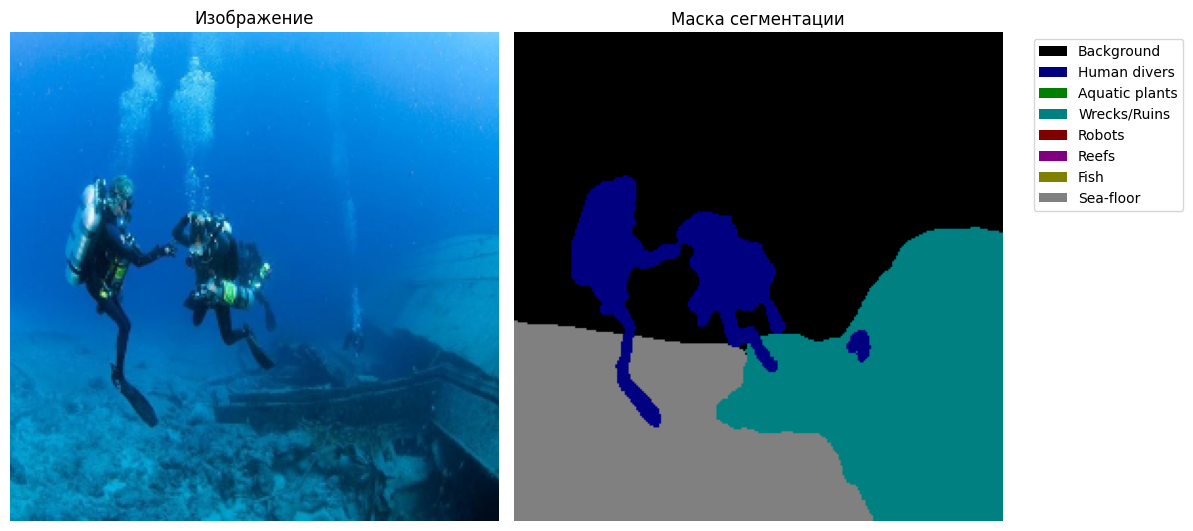

In [9]:
visualize_sample(train_dataset, idx=0)

In [ ]:
def mean_iou(pred, target, num_classes=NUM_CLASSES):
    pred = torch.argmax(pred, dim=1)
    ious = []

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls

        if target_inds.long().sum().item() == 0 and pred_inds.long().sum().item() == 0:
            ious.append(torch.tensor(1.0, device=pred.device))
            continue

        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()

        iou = (intersection + 1e-8) / (union + 1e-8)
        ious.append(iou)

    return torch.stack(ious).mean()

## 2.1 Обучение Unet

Определим две ключевые функции жизненного цикла обучения:
- train_epoch: обучает модель на одной эпохе данных, вычисляет градиенты и обновляет веса
- validate_epoch: оценивает модель на валидационных данных без обновления весов

In [11]:
def train_epoch(model, loader, optimizer, criterion, device, metrics_fn=None):
    model.train()
    total_loss = 0
    total_metrics = 0

    with tqdm(loader, desc="Training", leave=False) as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_loss += batch_loss

            if metrics_fn:
                metrics = metrics_fn(outputs, masks)
                total_metrics += metrics.item() if isinstance(metrics, torch.Tensor) else metrics
                pbar.set_postfix(loss=batch_loss, metrics=metrics.item() if isinstance(metrics, torch.Tensor) else metrics)
            else:
                pbar.set_postfix(loss=batch_loss)

    average_loss = total_loss / len(loader)
    average_metrics = total_metrics / len(loader) if metrics_fn else None

    return average_loss, average_metrics

def validate_epoch(model, loader, criterion, device, metrics_fn=None):
    model.eval()
    total_loss = 0
    total_metrics = 0

    with torch.no_grad():
        with tqdm(loader, desc="Validation", leave=False) as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.long().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                batch_loss = loss.item()
                total_loss += batch_loss

                if metrics_fn:
                    metrics = metrics_fn(outputs, masks)
                    total_metrics += metrics.item() if isinstance(metrics, torch.Tensor) else metrics
                    pbar.set_postfix(loss=batch_loss, metrics=metrics.item() if isinstance(metrics, torch.Tensor) else metrics)
                else:
                    pbar.set_postfix(loss=batch_loss)

    average_loss = total_loss / len(loader)
    average_metrics = total_metrics / len(loader) if metrics_fn else None

    return average_loss, average_metrics

и затем основная функция обучения и вспомогательная функция для построения графика

In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10,
    scheduler=None,
    metrics_fn=None,
):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': [],
        'val_metrics': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, device, metrics_fn
        )

        val_loss, val_metrics = validate_epoch(
            model, val_loader, criterion, device, metrics_fn
        )

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if metrics_fn:
            history['train_metrics'].append(train_metrics)
            history['val_metrics'].append(val_metrics)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        if metrics_fn:
            print(f"Train Metrics: {train_metrics:.4f}")
            print(f"Val Metrics: {val_metrics:.4f}")
        print("-" * 30)

    return model, history

def plot_training_history(history, metrics_name="IoU"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    if 'train_metrics' in history and len(history['train_metrics']) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(history['train_metrics'], label='Train')
        plt.plot(history['val_metrics'], label='Validation')
        plt.title(metrics_name)
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

Создаём модель, загружаем на gpu

In [13]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [14]:
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3151
Val Loss: 0.9059
Train Metrics: 0.2481
Val Metrics: 0.3827
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8917
Val Loss: 0.7580
Train Metrics: 0.4206
Val Metrics: 0.4946
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7758
Val Loss: 0.7317
Train Metrics: 0.4837
Val Metrics: 0.4814
------------------------------


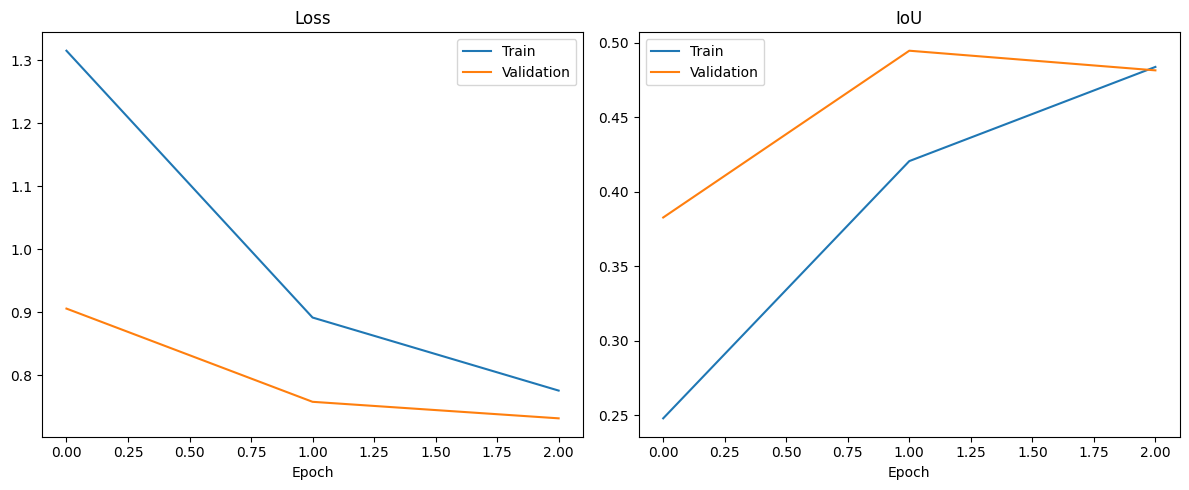

In [15]:
plot_training_history(history)

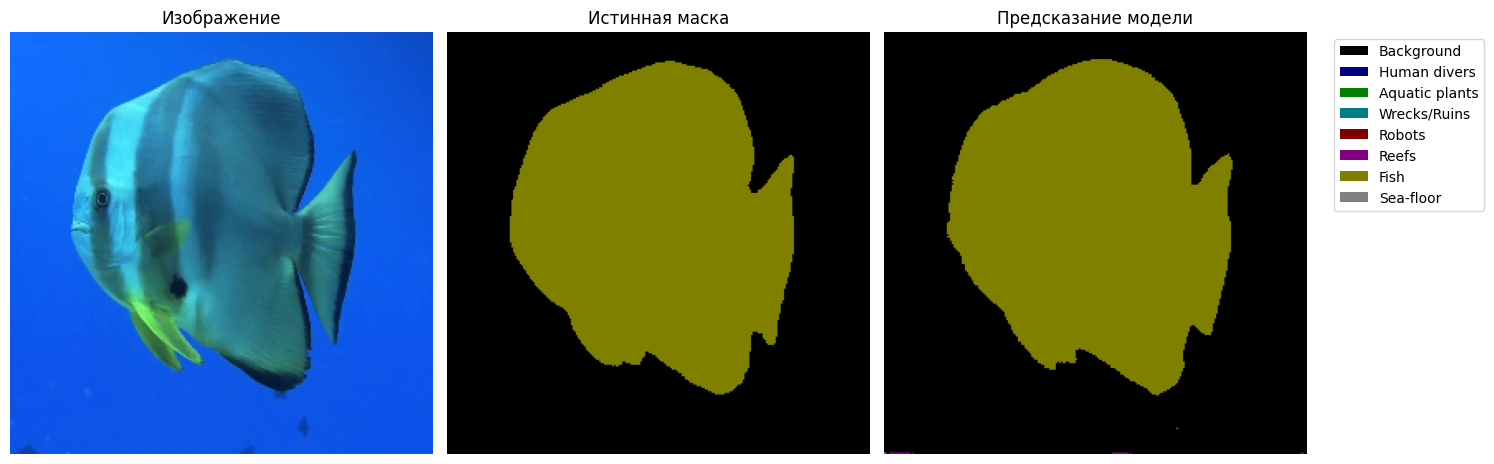

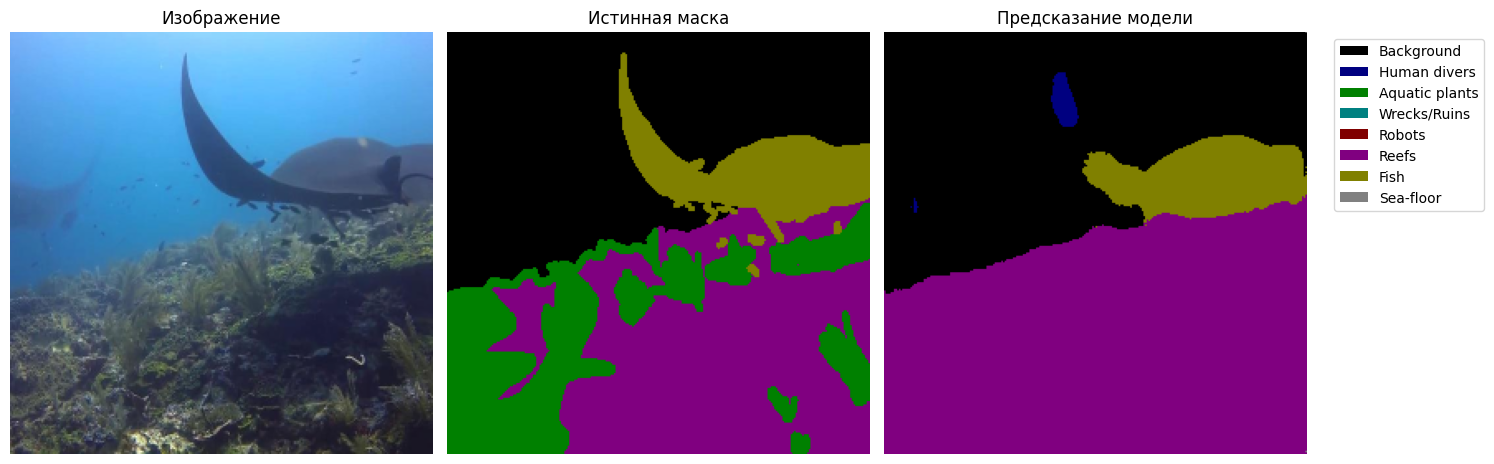

In [16]:
visualize_predictions(trained_model, train_dataset, DEVICE, num_samples=2)

Видно, что модель относительно хорошо справилась с семантической сегментацией изображения. Видны основные объекты, и их классы соотвествуют разметке. Попробуем улучшить точность модели

## 2.2 Улучшенный бейзлайн Unet

Для улучшения точности модели попробуем применить следующие методы:
- добавить больше данных
- использовать более сложный энкодер

In [17]:
unet_improved = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_improved.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/home/jupyter/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading efficientnet-b3 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 70.8MB/s]


Определим аугментации для увеличения вариативности тренировочных изображений. Включим преобразования:

отражения, повороты, цветовые, деформации, шумы и фильтры, улучшение деталей
Эти преобразования помогают модели лучше обобщать и справляться с вариативностью в реальных данных.

In [18]:
improved_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.4),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
    ], p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(p=0.3),
        A.Blur(blur_limit=(3, 7), p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=(0.1, 2.0), p=0.3),
    ], p=0.3),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [19]:
improved_train_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=improved_transform), train_indices)
improved_val_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), val_indices)

improved_train_loader = DataLoader(improved_train_dataset, batch_size=8, shuffle=True)
improved_val_loader = DataLoader(improved_val_dataset, batch_size=8, shuffle=False)

print(f"Количество тренировочных изображений: {len(improved_train_dataset)}")
print(f"Количество валидационных изображений: {len(improved_val_dataset)}")

Количество тренировочных изображений: 1372
Количество валидационных изображений: 153


In [20]:
improved_trained_model, improved_history = train_model(
    model=unet_improved,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=5,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5578
Val Loss: 1.0768
Train Metrics: 0.1616
Val Metrics: 0.2098
------------------------------
Epoch 2/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.1378
Val Loss: 0.8971
Train Metrics: 0.2204
Val Metrics: 0.2735
------------------------------
Epoch 3/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.0195
Val Loss: 0.7811
Train Metrics: 0.2685
Val Metrics: 0.4083
------------------------------
Epoch 4/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9279
Val Loss: 0.7343
Train Metrics: 0.3616
Val Metrics: 0.4465
------------------------------
Epoch 5/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8598
Val Loss: 0.6739
Train Metrics: 0.4162
Val Metrics: 0.4588
------------------------------


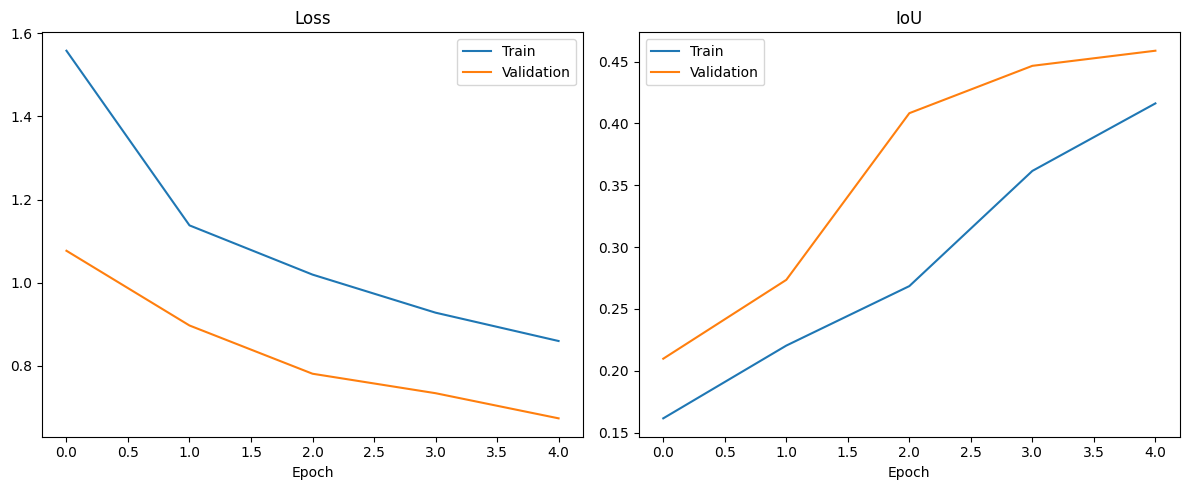

In [21]:
plot_training_history(improved_history)

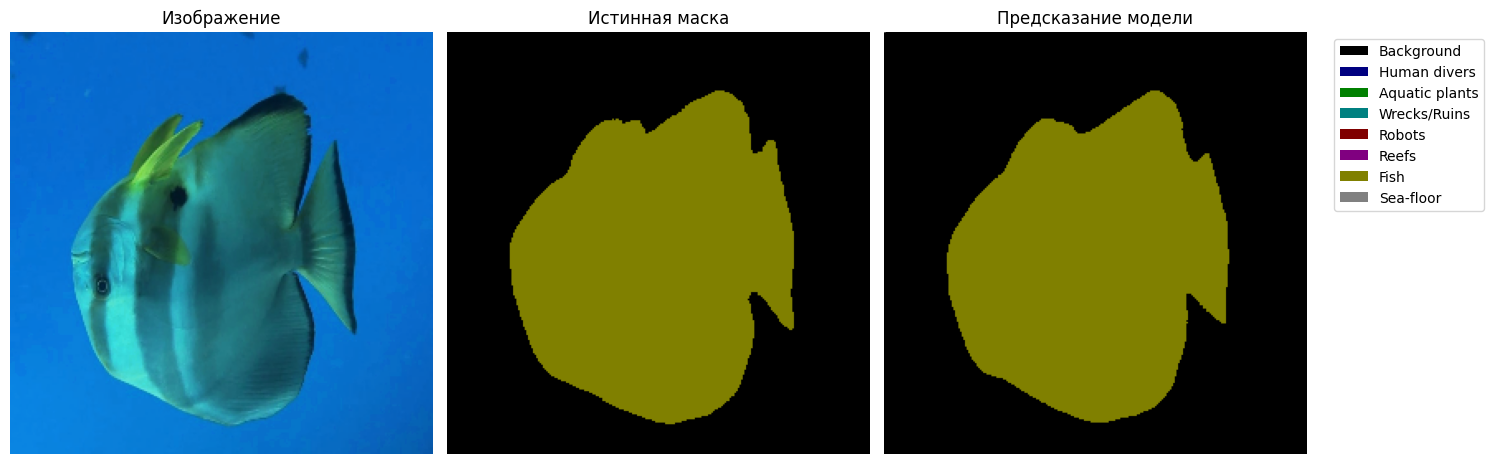

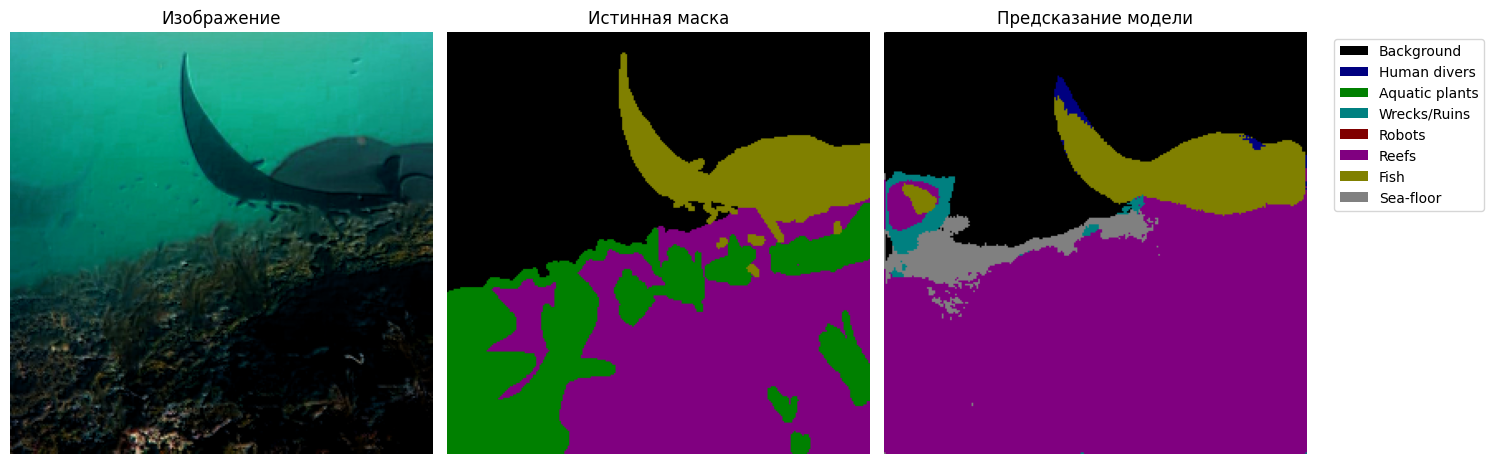

In [22]:
visualize_predictions(improved_trained_model, improved_train_dataset, DEVICE, num_samples=2)

По  результатам запусков, видно, что разнообразие данных, не помогло модели лучше начать распозновать объекты. Хотя визуально видно, что классы определяются неверно, внутри верно определённых форм. Что вероятно говоорит о том, что недостаточно эпох обучения прошло, для обучения модели, это так же можно наблюдать на графике, так как метрика продолжает изменяться

## 2.3 Собственная имплементация Unet

Напишем свою простейшую реализацию UNet модели

In [23]:
class SimpleUNet(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.enc1 = self._conv_block(3, 32)
        self.enc2 = self._conv_block(32, 64)

        self.middle = self._conv_block(64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)  # 128 = 64 (от enc2) + 64 (от up1)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(64, 32)   # 64 = 32 (от enc1) + 32 (от up2)

        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        m = self.middle(p2)

        u1 = self.up1(m)
        u1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        u2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(u2)

        return self.final(d2)

In [24]:
custom_unet = SimpleUNet().to(DEVICE)
custom_optimizer = torch.optim.Adam(custom_unet.parameters(), lr=1e-4)

In [25]:
trained_custom_unet, custom_history = train_model(
    model=custom_unet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=custom_optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.7412
Val Loss: 1.4855
Train Metrics: 0.1436
Val Metrics: 0.1699
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4855
Val Loss: 1.3281
Train Metrics: 0.1783
Val Metrics: 0.2881
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3699
Val Loss: 1.2340
Train Metrics: 0.2159
Val Metrics: 0.3234
------------------------------


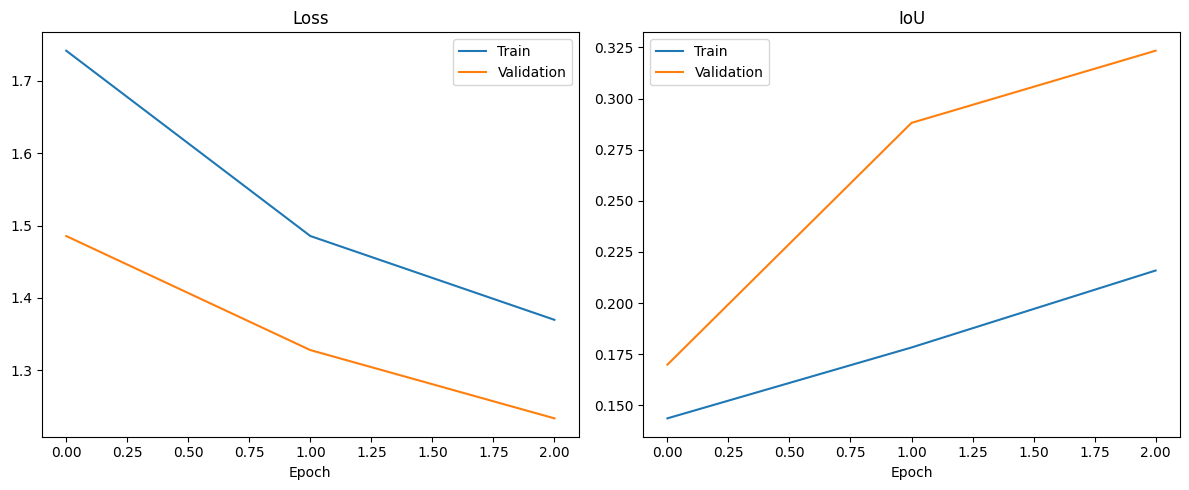

In [26]:
plot_training_history(custom_history)

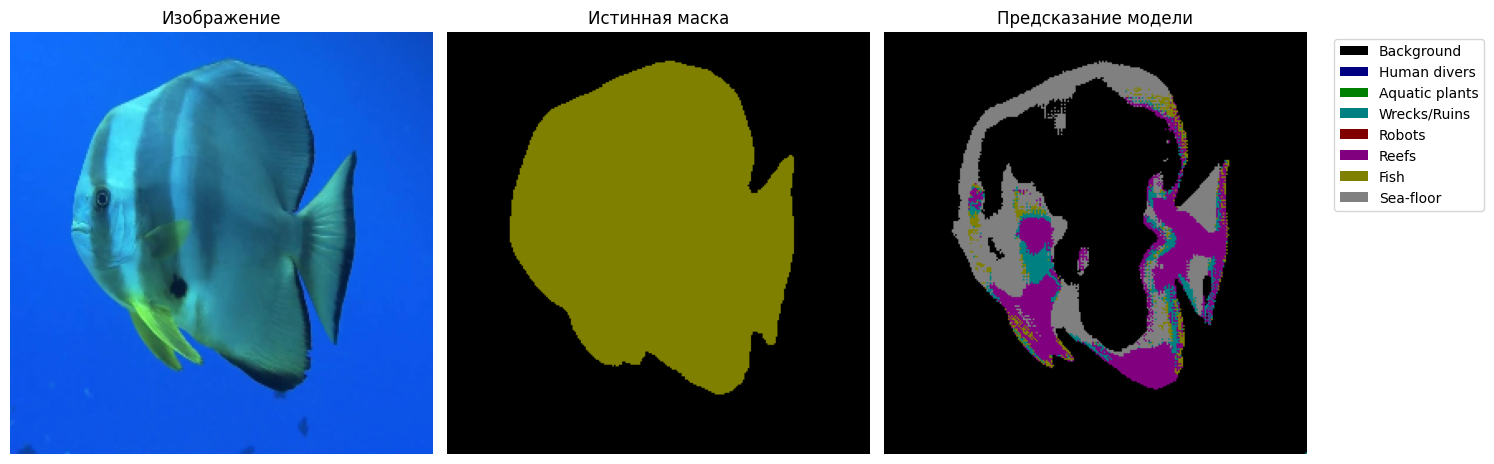

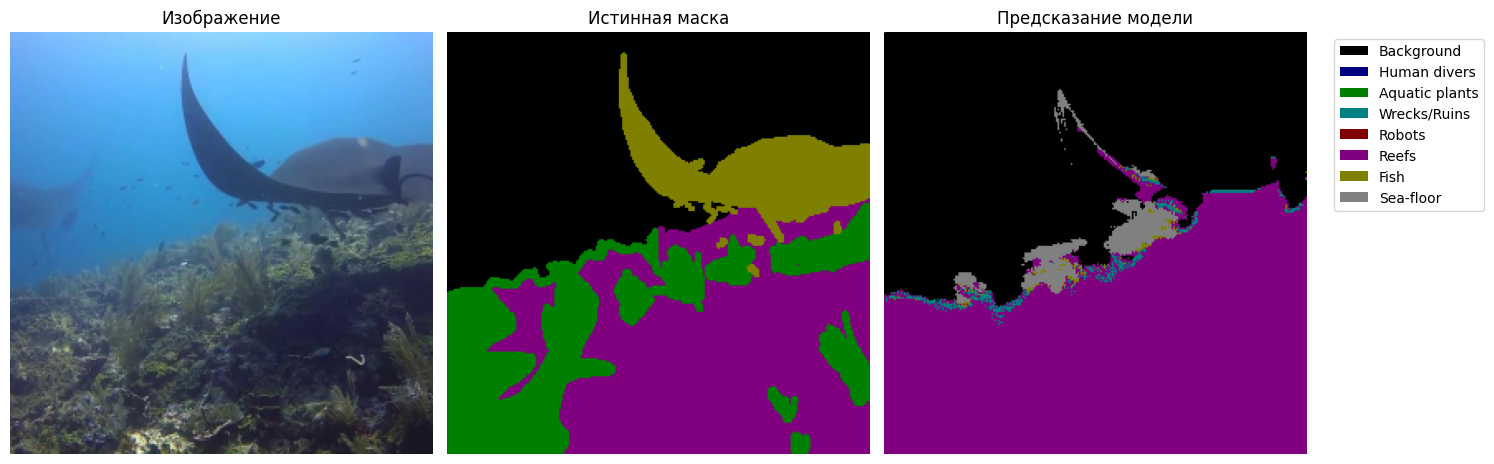

In [27]:
visualize_predictions(trained_custom_unet, train_dataset, DEVICE, num_samples=2)

Ожидаемо, модель не показала выдающихся результатов, попробуем улучшить её достижения

## 2.4 Улучшенный бейзлайн собственной имплементаци Unet

В этот раз, попробуем поменять архитектуру модели вместе с увеличением разнообразия данных

In [28]:
class ImprovedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.final = nn.Conv2d(64, 8, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)

        u1 = self.up1(c3)
        d1 = self.dec1(torch.cat([u1, c2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, c1], dim=1))
        return self.final(d2)

In [29]:
improved_custom_unet = ImprovedUNet().to(DEVICE)
custom_optimizer = torch.optim.Adam(improved_custom_unet.parameters(), lr=1e-4)

In [42]:
trained_improved_custom_unet, custom_history = train_model(
    model=improved_custom_unet,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=custom_optimizer,
    device=DEVICE,
    epochs=5,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/5

Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3128
Val Loss: 1.1892
Train Metrics: 0.2691
Val Metrics: 0.4562
------------------------------
Epoch 2/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3084
Val Loss: 1.1923
Train Metrics: 0.2654
Val Metrics: 0.4572
------------------------------
Epoch 3/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.2972
Val Loss: 1.1690
Train Metrics: 0.2681
Val Metrics: 0.4511
------------------------------
Epoch 4/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.
Train Loss: 1.2912
Val Loss: 1.1650
Train Metrics: 0.2664
Val Metrics: 0.4526
------------------------------
Epoch 5/5


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.2706
Val Loss: 1.1919
Train Metrics: 0.2633
Val Metrics: 0.4531
------------------------------


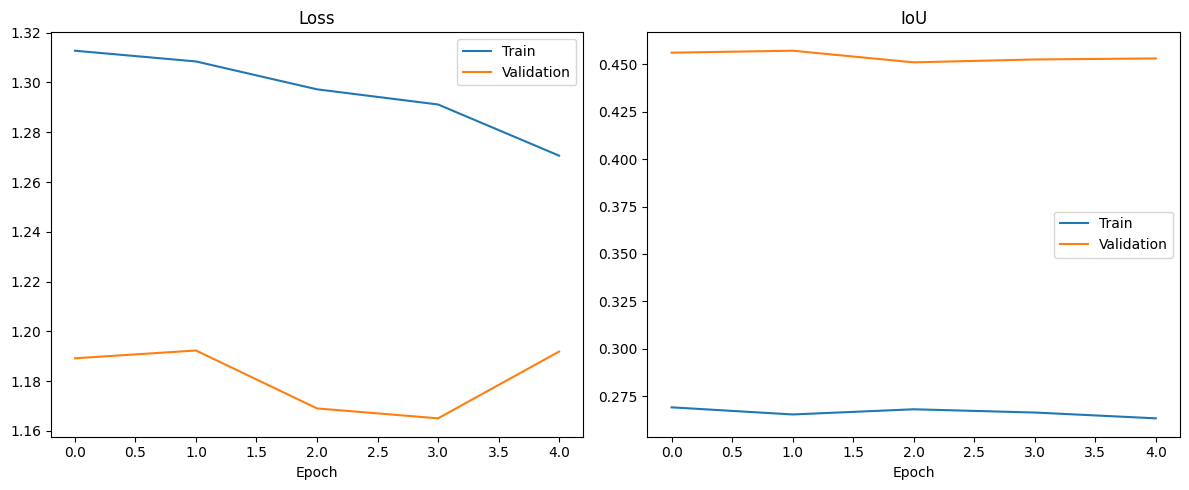

In [43]:
plot_training_history(custom_history)

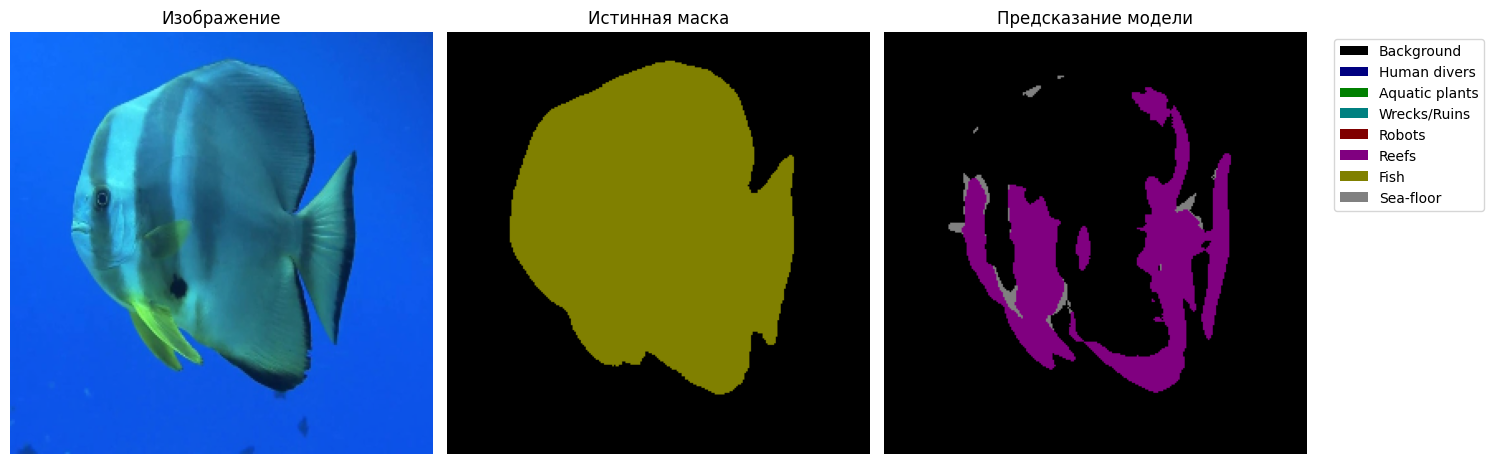

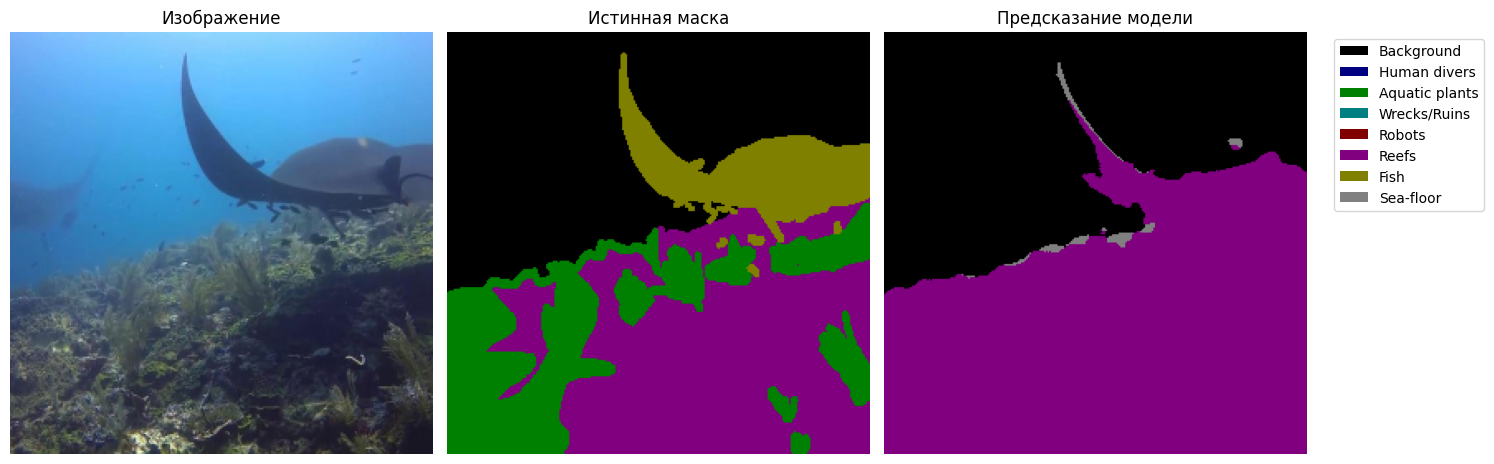

In [44]:
visualize_predictions(trained_improved_custom_unet, train_dataset, DEVICE, num_samples=2)

В целом видно некотрое отсутсвиелишнего шума. Но ощутимых результатов добиться не получилось. Что касается метрик, то с обновлённой моделью и аугментированными ланными, метрика модели повысилась, что говорит о верном направлении улучшении. Вероятно стоит пообучать модель подольше, но текущее оборудование не позволяет эксперементировать, в силу ограниченности бесплатных вычислительных ресурсов!

## 2.5 Обучение трансформера

In [33]:
segformer = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(DEVICE)

/home/jupyter/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading mit_b0 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)
Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /tmp/xdg_cache/torch/hub/checkpoints/mit_b0.pth
100%|██████████| 13.7M/13.7M [00:00<00:00, 34.1MB/s]


In [34]:
optimizer = torch.optim.Adam(segformer.parameters(), lr=1e-4)

In [35]:
trained_segformer, history = train_model(
    model=segformer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9380
Val Loss: 0.7279
Train Metrics: 0.3854
Val Metrics: 0.4879
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.6246
Val Loss: 0.5801
Train Metrics: 0.5064
Val Metrics: 0.5539
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.5347
Val Loss: 0.6395
Train Metrics: 0.5552
Val Metrics: 0.5667
------------------------------


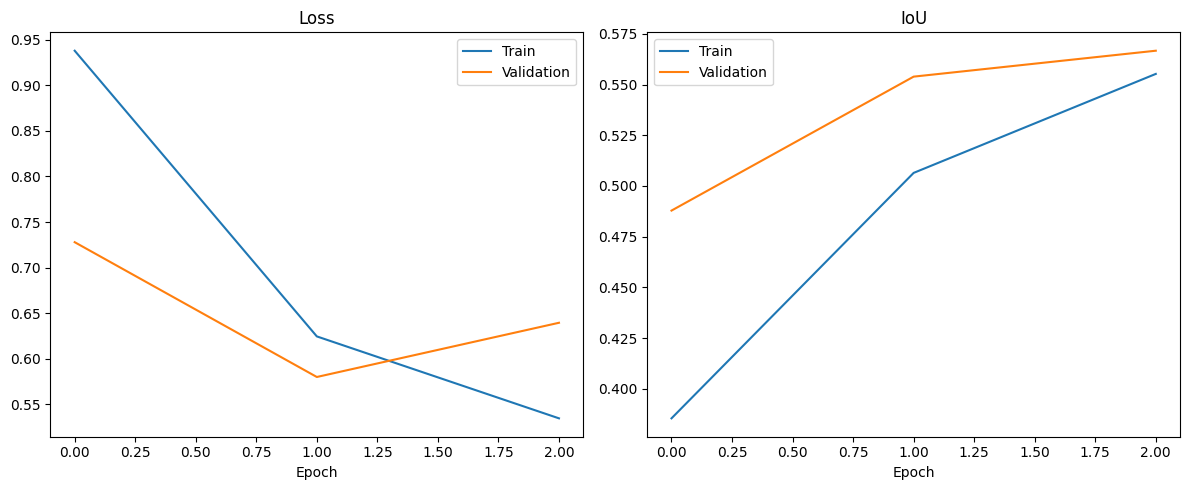

In [36]:
plot_training_history(history)

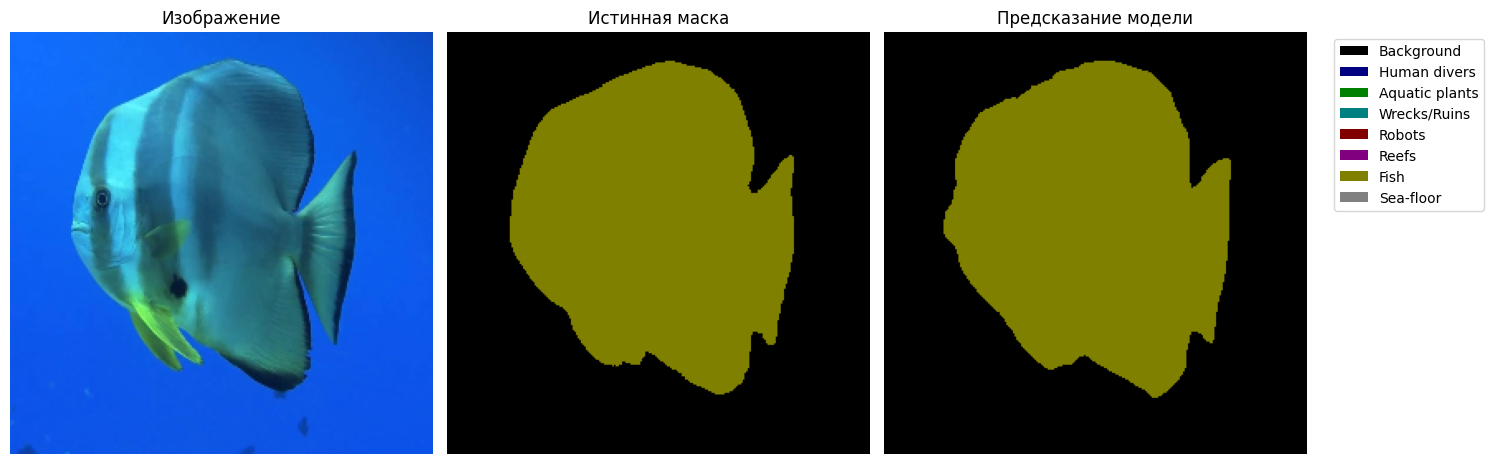

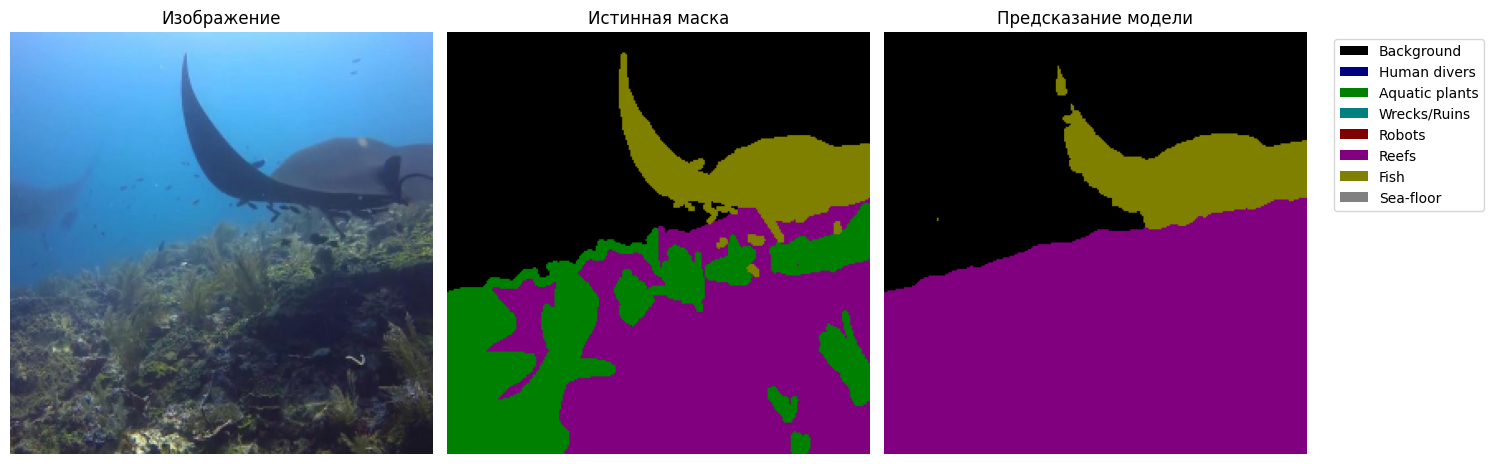

In [37]:
visualize_predictions(trained_segformer, train_dataset, DEVICE, num_samples=2)

Сразу видно превосходство модели на Unet. Модель лучше сегментирует, практически не ошибается (относительного предыдущих экспериментов) и показывает лучшее значение метрики. Попробуем ещё улучшить с помощью имеющихся аугментированных данных

## 2.6 Улучшенный бейзлайн обучения трансформера

In [38]:
improved_segformer, improved_history = train_model(
    model=segformer,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7075
Val Loss: 0.5906
Train Metrics: 0.4764
Val Metrics: 0.5365
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.6604
Val Loss: 0.5655
Train Metrics: 0.4900
Val Metrics: 0.5819
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.6102
Val Loss: 0.5271
Train Metrics: 0.5259
Val Metrics: 0.5924
------------------------------


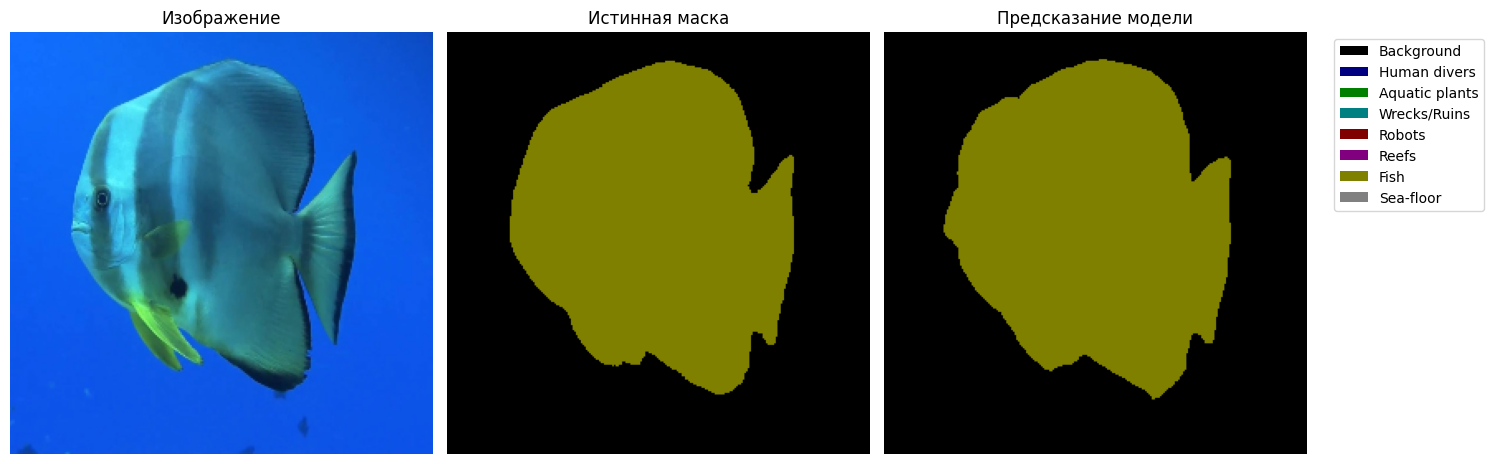

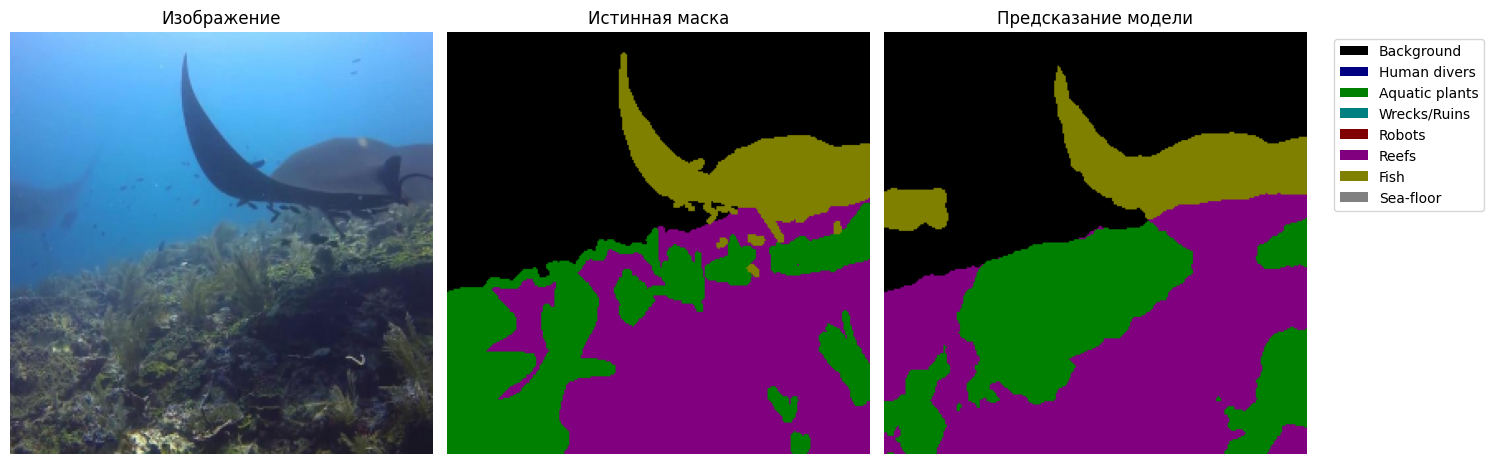

In [39]:
visualize_predictions(improved_segformer, train_dataset, DEVICE, num_samples=2)

Модель стала ещё лучше классифицировать пиксели, а так же смогла даже распознать  силует рыбы, который даже не был размечен в датасете, хотя явно является рыбой! так же результаты видны и на метриках!

## 2.7 Собственная имплементация транформера

Попробуем написать собственную реализацию трансформенной модели с учетом размеров слоёв

In [ ]:
class SimpleTransformerSegmentation(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, num_classes=8,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)
        )


    def forward(self, x):
        input_size = x.shape[2:]

        x = self.patch_embed(x)

        B, C, H_embed, W_embed = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = x.transpose(1, 2).reshape(B, C, H_embed, W_embed)

        x = self.decoder(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_output

        x_norm = self.norm2(x)
        mlp_output = self.mlp(x_norm)
        x = x + mlp_output
        return x

In [49]:
custom_segformer = SimpleTransformerSegmentation(
    img_size=256,
    patch_size=16,
    in_channels=3,
    num_classes=NUM_CLASSES,
    embed_dim=256,
    depth=6,
    num_heads=8,
    dropout=0.1
).to(DEVICE)
optimizer = torch.optim.AdamW(custom_segformer.parameters(), lr=5e-5, weight_decay=1e-4)

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.9754
Val Loss: 1.7851
Train Metrics: 0.0824
Val Metrics: 0.1056
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.7742
Val Loss: 1.6220
Train Metrics: 0.1296
Val Metrics: 0.1447
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 1.2500e-05.
Train Loss: 1.6396
Val Loss: 1.4544
Train Metrics: 0.1537
Val Metrics: 0.1608
------------------------------


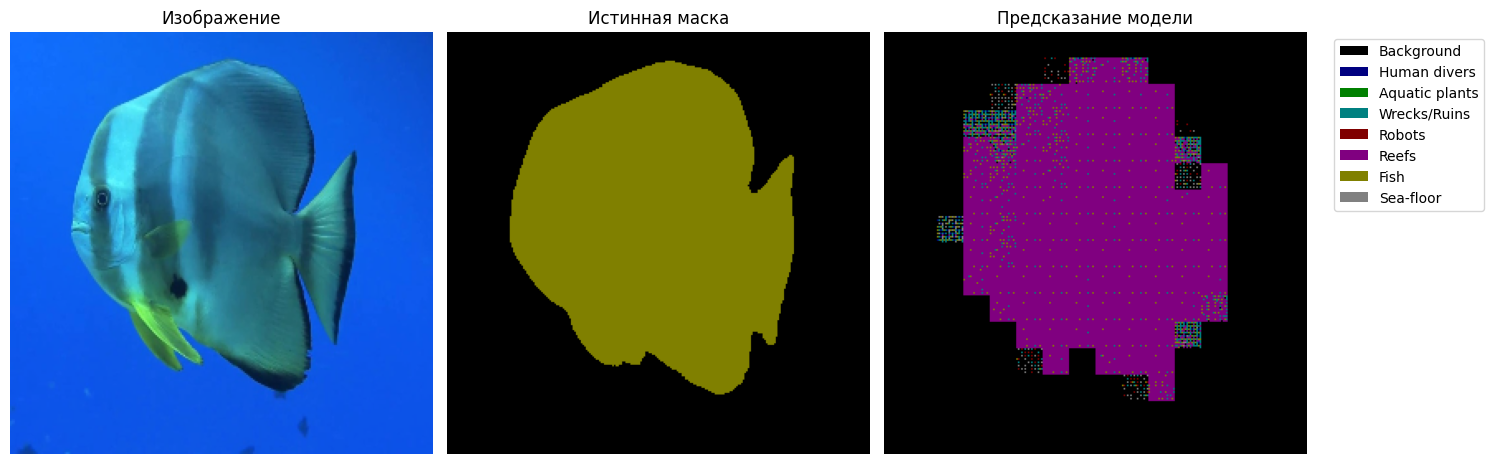

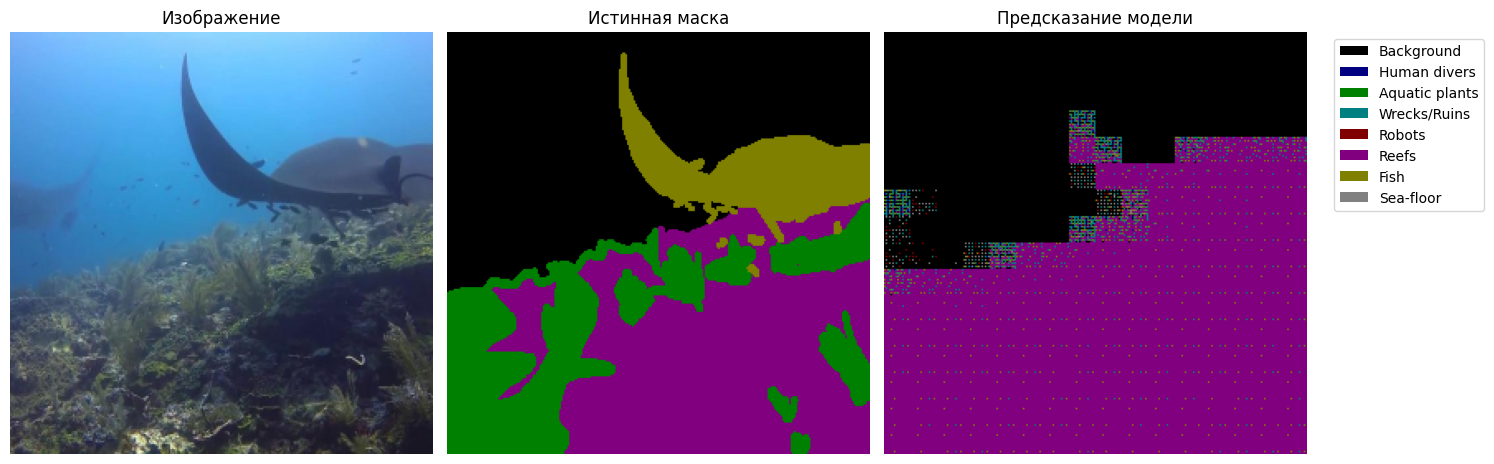

In [50]:
trained_custom_segformer, history = train_model(
    model=custom_segformer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)
visualize_predictions(trained_custom_segformer, train_dataset, DEVICE, num_samples=2)


Результат не впечетляющий, явно модель не успевает обощить, слишком сложная страктуру для такого набора данных. Можно попробовать улучшить, но скорее всего дело сильно лучше не пойдёт

## 2.8 Улучшенный бейзлайн обучения собственного трансформера

Epoch 1/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5526
Val Loss: 1.4175
Train Metrics: 0.1635
Val Metrics: 0.2098
------------------------------
Epoch 2/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4668
Val Loss: 1.3048
Train Metrics: 0.1838
Val Metrics: 0.2195
------------------------------
Epoch 3/3


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4030
Val Loss: 1.2055
Train Metrics: 0.2204
Val Metrics: 0.3166
------------------------------


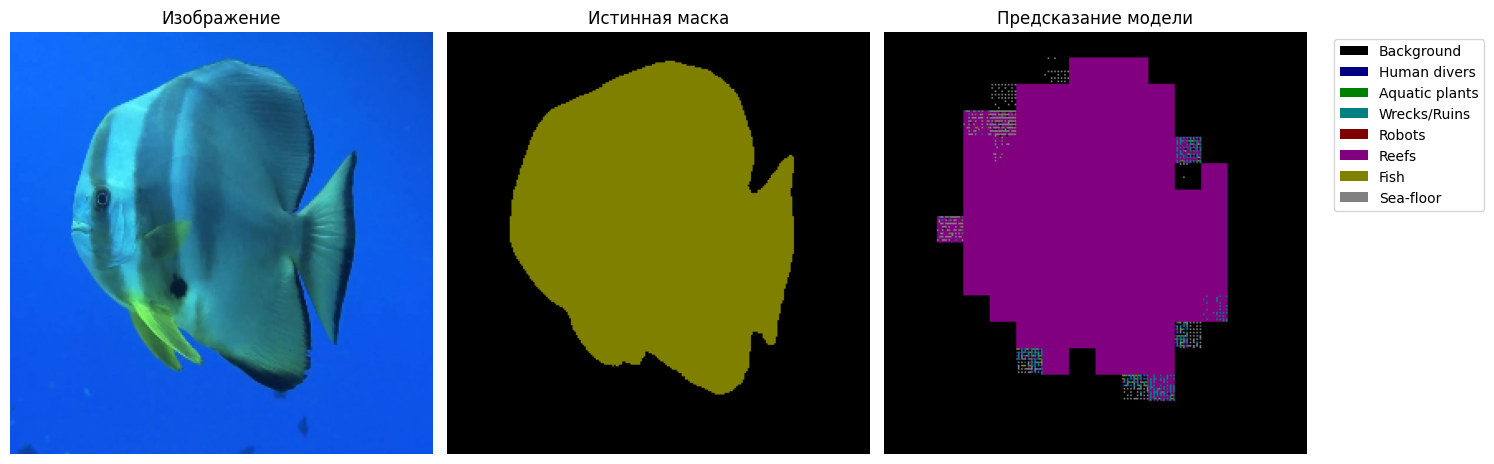

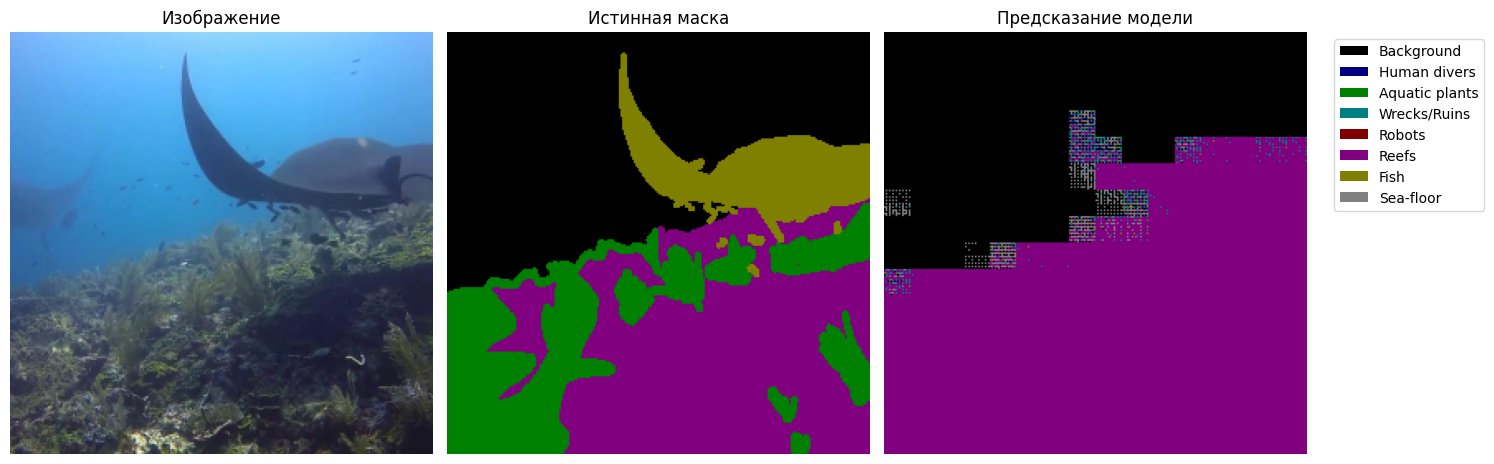

In [51]:
trained_improved_custom_segformer, history = train_model(
    model=custom_segformer,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)
visualize_predictions(trained_improved_custom_segformer, train_dataset, DEVICE, num_samples=2)

Таким образом улучшить собственную имплементацию не получилась, она проигрывает всем реализациям, в том числе самописной UNet. Хотя видно, что точность продолжает увеличиваться и количество шума на картинке уменьшается. Гипотеза, что необходимо увеличить время обучения

# Итоговые результаты

| Модель                    | IoU    |
|---------------------------|--------|
| UNet                      | 0.4588 |
| UNet improved             | 0.4814 |
| Custom UNet               | 0.3234 |
| Custom UNet improved      | 0.4531 |
| Segformer                 | 0.5667 |
| Segformer improved        | 0.5924 |
| Custom Segformer          | 0.1608 |
| Custom Segformer improved | 0.3166 |

# Заключение

В ходе экспериментов наилучшие результаты показала модель Segformer. Однако, собственная реализация этих моделей продемонстрировала более низкое качество предсказаний. Это указывает на возможную необходимость в укреплении архитектуры и детальной настройки гиперпараметров для кастомного подхода. Увеличение времени обучения и количества эпох могло бы также улучшить производительность кастомных моделей.

Улучшение стандартных версий моделей (UNet и Segformer) обеспечило незначительное повышение IoU, что позволяет предположить, что базовые реализации уже обладают оптимальными параметрами для данного датасета. Вероятно, специфика и сложность подводных изображений требуют специализированного подхода и более сложной архитектуры.

Кастомные реализации моделей демонстрируют потенциал к увеличению производительности при условии дальнейшей оптимизации и адаптации к характерным чертам подводных изображений.